# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Problem Statement:

    1. Which type of offers influence the customers more allowing the company to push offers better? Analysing the data based on a set of heuristics developed.
    
    2. Identifying the age groups and gender that highly viewed the offer and completed the offer purchase?
    i.e. offer received ---> offer viewed ---> offer completed.

In [215]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [216]:
pt = portfolio.copy()
pf = profile.copy()
ts = transcript.copy()

<b> <h3> portfolio.json </h3> </b> - - containing offer ids and meta data about each offer (duration, type, etc.)

<b> channels </b> - (list of strings)

<b> difficulty (int)</b> - minimum required spend to complete an offer

<b> duration (int) </b> - time for offer to be open, in days

<b> id (string) </b> - offer id

<b> offer_type (string) </b> - type of offer ie BOGO, discount, informational

<b> reward (int)</b> - reward given for completing an offer





In [217]:
pt.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [218]:
print(pt['id'].nunique())
print('-----------------------')
print(pt.groupby('offer_type')['id'].count())

10
-----------------------
offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64


We do here have 10 unique IDs (offer IDs) in which bogo and discount hold 4 each along with 2 belonging to informational.

In [219]:
def portfolio_cl(portfolio):
    '''
    Cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # Connverting the duration from day to hour
    pt['duration'] = pt['duration'] * 24
    
    # One-hot encoding applied to channels feature
    
    pt['web'] = pt['channels'].apply(lambda x: 1 if 'web' in x else 0)
    pt['email'] = pt['channels'].apply(lambda x: 1 if 'email' in x else 0)
    pt['mobile'] = pt['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    pt['social'] = pt['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # One-hot encoding applied to offer_type feature
    
    offer_type = pd.get_dummies(pt['offer_type'])
    
    # Drop the 'channels' and 'offer_type' features
    
    pt.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # Concating the portfolio(pt) and offer_type dataframe
    
    portfolio_cl = pd.concat([pt, offer_type], axis=1, sort=False)
    
    portfolio_cl = portfolio_cl.rename(columns={'id': 'offer_id'})
    
    return portfolio_cl # Returns the cleaned dataframe after one-hot encoding.

In [220]:
pt = portfolio_cl(pt)

In [221]:
pt.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


Overlooking the channels feature in the "portfolio" dataset, it is evident that we have nested listed holding categories of channels.

Variations with respect to the "difficulty" and "duration" features where their metrics differ as dollars and days. 

Preprocessing phase will involve handling these categogies in nested list via one-hot encoding technique. 

Feature scaling might be a solution to bring varying feature values under one roof. Choosing one of the scaling techniques according to the dataset will be explained further in the preprocessing phase.

<b> profile.json</b>

<b> age (int)</b> - age of the customer

<b> became_member_on (int) </b> - date when customer created an app account

<b> gender (str)</b> - gender of the customer (note some entries contain 'O' for other rather than M or F)

<b> id (str)</b> - customer id

<b> income (float) </b>- customer's income

In [222]:
pf.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [223]:
pf.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

There are some NULL values in the features like "gender" and "income". 

We have same amount of null values in both "gender" and "income" features which makes the task pretty easy.

<b> <h2> Data Preprocessing: </h2> </b>

In [140]:
pf = profile.copy()

In [224]:
pf['became_member_on'] = pd.to_datetime(pf['became_member_on'], format='%Y%m%d')

In [225]:
import calendar

yr = [dt.year for dt in pf['became_member_on']]
mth = [dt.month for dt in pf['became_member_on']]
dy = [calendar.day_name[dt.weekday()] for dt in pf['became_member_on']]

pf['membership_year'] = yr
pf['membership_month'] = mth
pf['membership_day'] = dy

pf = pf.drop(columns = ['became_member_on'])

In [226]:
pf.head(3)

,age,gender,id,income,membership_year,membership_month,membership_day
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,Sunday
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,Thursday


In [227]:
pf.dropna(inplace=True)
pf.head(3)

,age,gender,id,income,membership_year,membership_month,membership_day
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,Thursday


In [228]:
def profile_cl(profile_cl) :
    
    ''' This function processes the age feature and groups them
        
        Input:
        - df: profile dataframe
        
        Output:
        - df: dataframe after grouping the age feature '''
   

    # add new coulnm that group the ages .  

    profile_cl['age_group'] = profile_cl['age'].apply(lambda x: '18s' if 17<x<=19
                                                      else '20s' if 19<x<=29
                                                      else '30s' if 29<x<=39
                                                      else '40s' if 39<x<=49
                                                      else '50s' if 49<x<=59
                                                      else '60s' if 59<x<=69
                                                      else '70s' if 69<x<=79
                                                      else '80s' if 79<x<=89
                                                      else '90s' if 89<x<=102

                                                      else x )


    # chnage data type to be in order . 
    profile_cl['age_group'] = profile_cl.age_group.astype('category')
    

    return profile_cl

In [282]:
pf = profile_cl(pf)
pf.head()

,age,gender,customer_id,income,membership_year,membership_month,membership_day,age_group
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,50s
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday,70s
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,Thursday,60s
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,Friday,60s
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,Saturday,50s


In [230]:
pf.isnull().sum() # Checking the null values in profile dataset

age                 0
gender              0
id                  0
income              0
membership_year     0
membership_month    0
membership_day      0
age_group           0
dtype: int64

In [231]:
ts.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [232]:
ts.isnull().sum() # null value check with transcript dataset

event     0
person    0
time      0
value     0
dtype: int64

Great! We don't have any null values present in any of the features in the portfolio dataframe.

Profile dataset after eliminating all the Nan values existed. 

The end results after cleaning the portfolio dataframe looks better. Let's further check it detailed feature values using describe() method.

In [233]:
ts.head(3)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


Looking at the value feature of transcript  dataframe, there has to be some sort of data preprocessing needed to fetch the values alone from the feature. 

One idea could be creating a separate column offer_id holding its values.

In [234]:
ts.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [235]:
# % on the event distribution
ts.groupby('event').person.count()/ts.shape[0] * 100.00

event
offer completed    10.954413
offer received     24.883700
offer viewed       18.831516
transaction        45.330371
Name: person, dtype: float64

In [283]:
def  transcript_cl(df) :

    # copy df for cleaning 
    clean_trans = df.copy()

    #  rename person col name to customer_id.
    clean_trans.rename(columns={'person': 'customer_id'}, inplace=True)

    # Remove customer ids that are not in the profile dataset .

    match_ids = clean_trans['customer_id'].isin(pf['customer_id'])
    clean_trans =clean_trans[match_ids]


    # extract all values in dictionary format under column 'value' and update the column .

    clean_trans['value'] = clean_trans['value'].apply(lambda x: list(x.values())[0])


    # Delete 'transaction' rows from dataFrame (not needed for my project case) .

    trans_index = clean_trans[clean_trans['event'] == 'transaction' ].index
    clean_trans.drop(trans_index , inplace=True)

    # after extraction , rename value col name to offer_id.
    clean_trans.rename(columns={'value': 'offer_id'}, inplace=True)
    
    # mapping offer type in protofilo  to offer_id           
    offers_map = {

    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
    '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo',
    'f19421c1d4aa40978ebb69ca19b0e20d':'bogo',
    '3f207df678b143eea3cee63160fa8bed':'informational',
    '5a8bc65990b245e5a138643cd4eb9837':'informational',
    'fafdcd668e3743c1bb461111dcafc2a4' : 'discount',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
    '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount',
    '2906b810c7d4411798c6938adc9daaa5':'discount'}

    # creating offer_type column 
    clean_trans['offer_type'] =  clean_trans['offer_id'].map(offers_map)
    
    # drop 'offer_id' column
    
    #cleaned_transcript.drop(['offer_id'], axis = 1, inplace= True) 
    
    # convert time from hours to days 
    clean_trans['time'] /= 24
    
    #cleaned_transcript.set_index('customer_id', inplace = True)
    
    


    return clean_trans

In [284]:
ts = transcript_cl(ts)

In [285]:
ts.head()

,event,customer_id,time,offer_id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,discount
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,informational
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount


In [239]:
ts['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

<b> <h2> Data Exploration: </h2> <b>

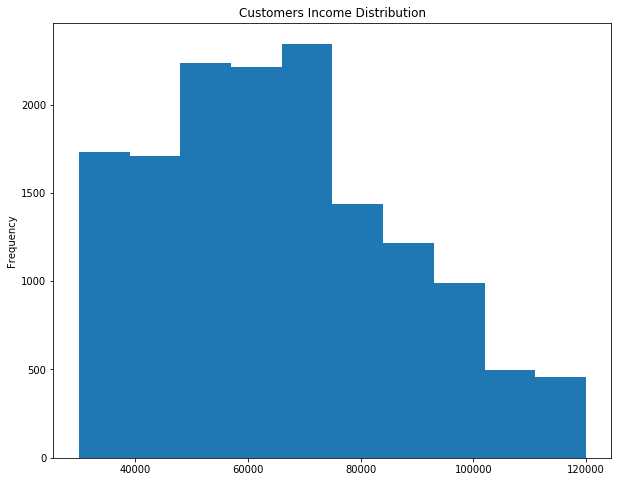

In [278]:
# Histogram of customer income.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

pf['income'].plot.hist()

plt.title('Customers Income Distribution')

plt.show()

Customer Income plays a significant role as far as offer completion is concerned. Lets further analyse with other features on to whic age groups and genders the offers are pushed. Also, try to categorize which one among them made high contribution to compeletion.

Text(0.5,0,'Age')

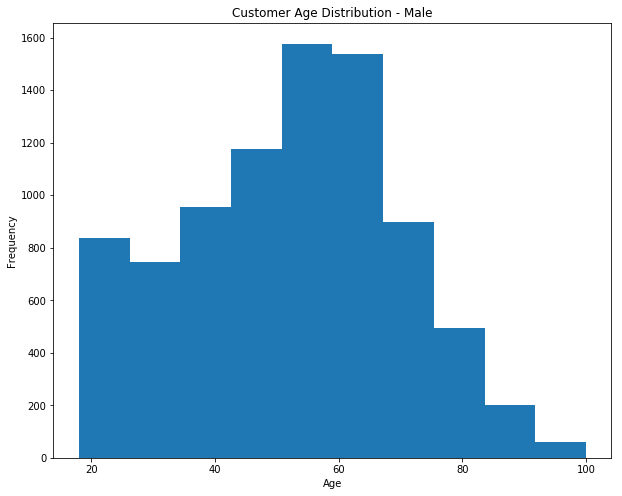

In [277]:
plt.figure(figsize=(10, 8))
plt.hist(x=pf['age'][pf['gender'] == 'M'])
plt.title('Customer Age Distribution - Male')
plt.ylabel('Frequency')
plt.xlabel('Age')

Text(0.5,1,'Customer Age Distribution - Female')

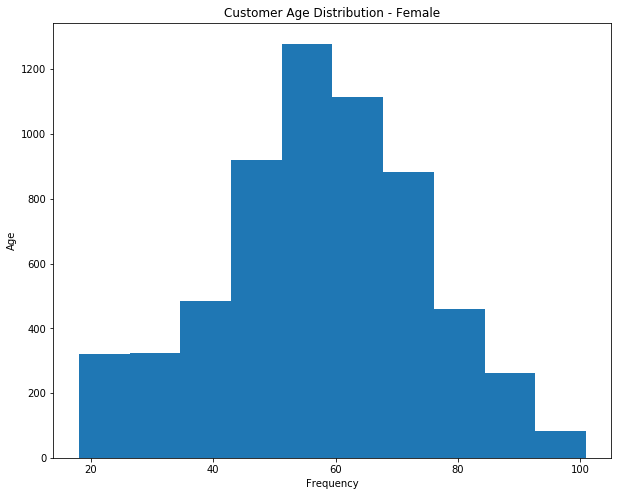

In [276]:
plt.figure(figsize=(10, 8))
plt.hist(x=pf['age'][pf['gender'] == 'F'])
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.title('Customer Age Distribution - Female')

Text(0.5,1,'Customer Age Distribution - Others')

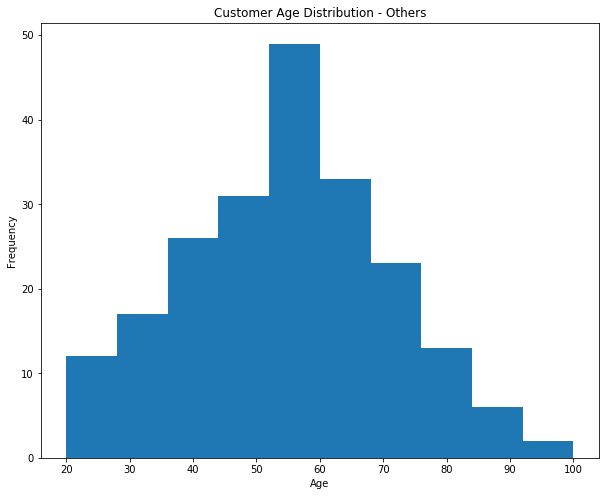

In [275]:
plt.figure(figsize=(10, 8))
plt.hist(x=pf['age'][pf['gender'] == 'O'])
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Customer Age Distribution - Others')

The histograms depict that Females being the highest no. of customers to whom the offers are more frequently promoted/pushed followed by "Others" and "Males" categories. 

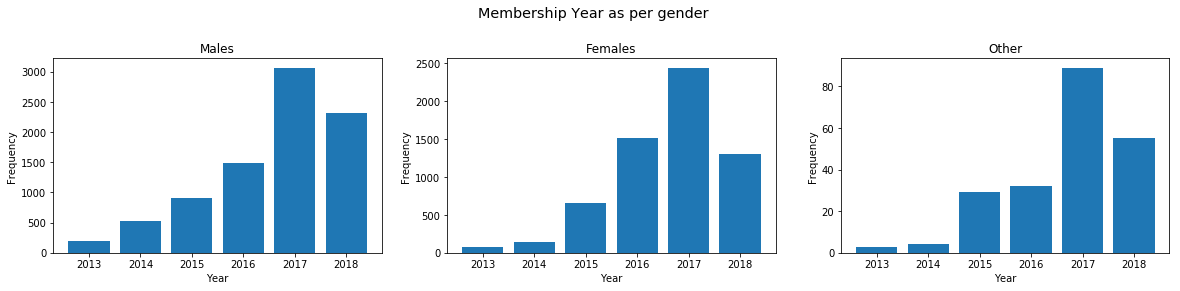

In [244]:
# Counting of members accordingly as per membership year.

fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.bar(x=pd.value_counts(pf['membership_year'][pf['gender'] == 'M']).index, height=pd.value_counts(pf['membership_year'][pf['gender'] == 'M']))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Males')

plt.sca(ax[1])
plt.bar(x=pd.value_counts(pf['membership_year'][pf['gender'] == 'F']).index, height=pd.value_counts(pf['membership_year'][pf['gender'] == 'F']))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Females')

plt.sca(ax[2])
plt.bar(x=pd.value_counts(pf['membership_year'][pf['gender'] == 'O']).index, height=pd.value_counts(pf['membership_year'][pf['gender'] == 'O']))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Other')

fig.suptitle('Membership Year as per gender', fontsize='x-large')
fig.subplots_adjust(top=0.80)

1. 2017 seems to have highest number of memberships acquired year.

2. The lowest among all these is the year 2013 where across all the three gendres, it marked the lowest.

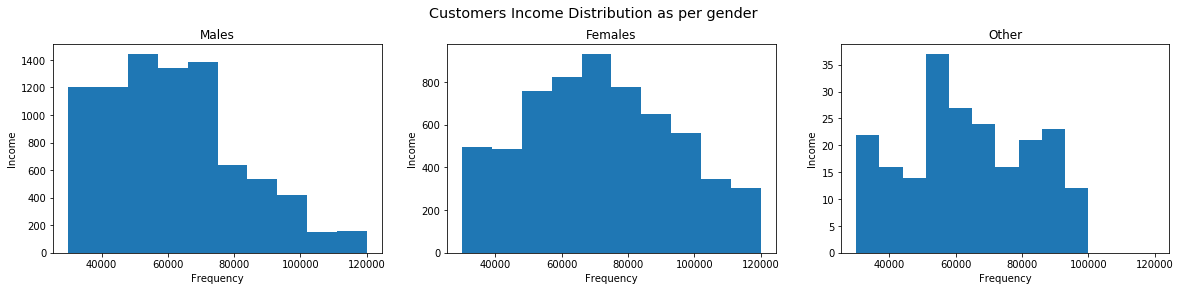

In [245]:
# Customer Income distribution as per gender depicted by histogram.

fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.hist(x=pf['income'][pf['gender'] == 'M'])
plt.xlabel('Frequency')
plt.ylabel('Income')
plt.title('Males')

plt.sca(ax[1])
plt.hist(x=pf['income'][pf['gender'] == 'F'])
plt.xlabel('Frequency')
plt.ylabel('Income')
plt.title('Females')

plt.sca(ax[2])
plt.hist(x=pf['income'][pf['gender'] == 'O'])
plt.xlabel('Frequency')
plt.ylabel('Income')
plt.title('Other')

fig.suptitle('Customers Income Distribution as per gender', fontsize='x-large')
fig.subplots_adjust(top=0.85)

1. This is directly proportional to what we observed in the gender graph.

2. Female Cateogory seems to hold highest income value as compared to the other two categories.

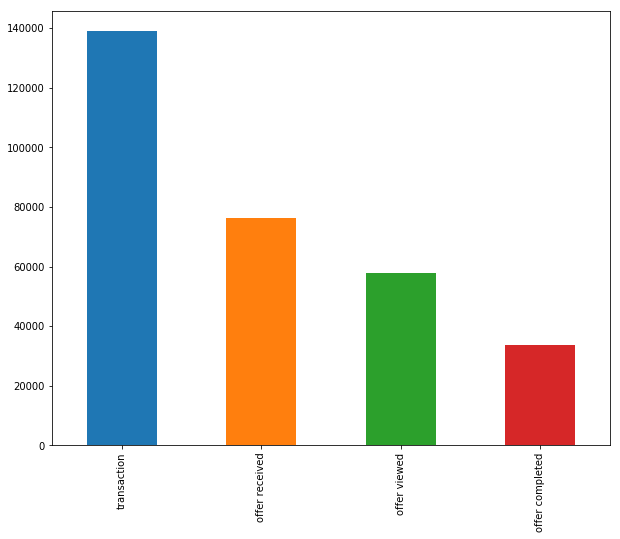

In [274]:
plt.figure(figsize=(10, 8))
pd.value_counts(ts['event']).plot.bar()

This the general flow where we have more customers receiving offers from the company and there is some amount of people who have viewed the offers and even lower compared to those viewed have completed the transaction and purchase.

- `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)

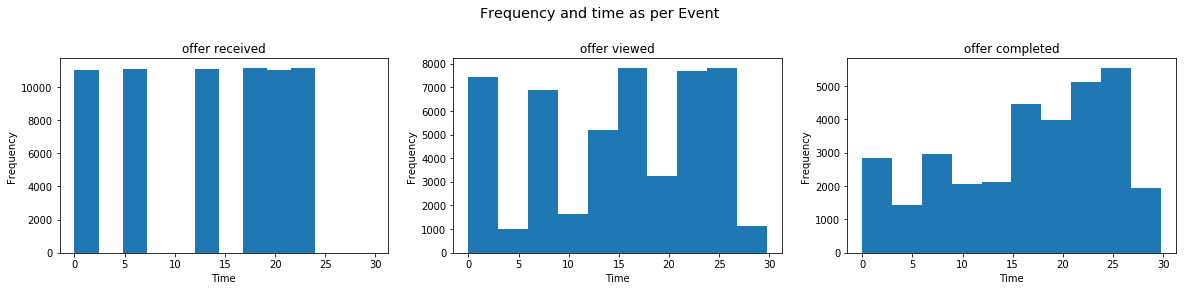

In [247]:
# Frequency and time histogram plots as per event

fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.hist(x=ts['time'][ts['event'] == 'offer received'])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('offer received')

plt.sca(ax[1])
plt.hist(x=ts['time'][ts['event'] == 'offer viewed'])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('offer viewed')

plt.sca(ax[2])
plt.hist(x=ts['time'][ts['event'] == 'offer completed'])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('offer completed')

fig.suptitle('Frequency and time as per Event', fontsize='x-large')
fig.subplots_adjust(top=0.80)

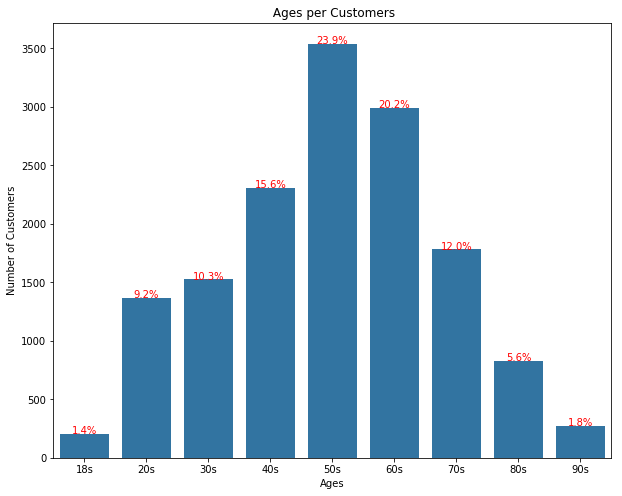

In [273]:
# plot age group .

import seaborn as sb

plt.figure(figsize=(10, 8))

base_color = sb.color_palette()[0]
sb.countplot(data = pf, x = 'age_group', color= base_color ) ;
plt.xlabel('Ages');
plt.title(' Ages per Customers');
plt.ylabel('Number of Customers');

# add annotations to show percentages for each age group .
n_cus = pf.shape[0]
cus_counts = pf['age_group'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

# get the text property for the label to get the correct count
     count = cus_counts[label.get_text()]
     pct_string = '{:0.1f}%'.format(100*count/n_cus);

# print the annotation just below the top of the bar
     plt.text(loc, count-0, pct_string, ha = 'center', color = 'r');

According to the bar graph shown above, I think 50s group leads the customer base as in, the number of customer in that group seems to be dominating/high of an overall 23.9% followed by the 60s with 20% next. The lowest of all is the 18s where it is just 1.4% of customer base along with second lowest of 90s with 1.8%.

Obviously, it is easily predictable why the 18s and 90s aren't to the mark, as it could be due to the fact that they are not interested toward these offer types or may be they usual never both about discounts and at times, it could be they neglect these things unknowingly.

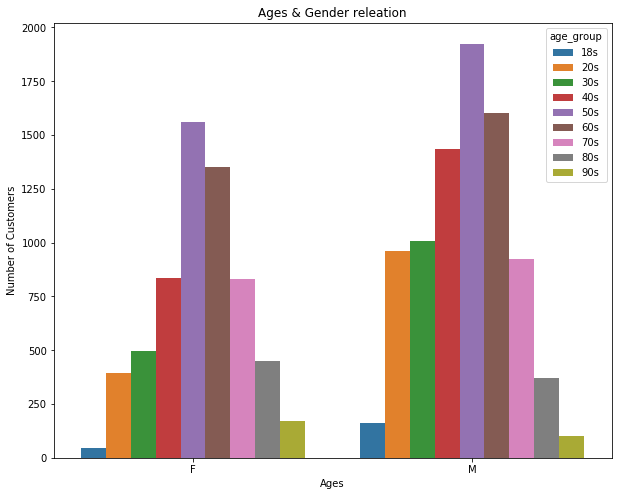

In [272]:
# exclude gender = 'O'  from the cleaned dataset to show the  Age Distribution .

df = pf[pf['gender']!='O']

plt.figure(figsize=(10, 8))

# display Bar chart for two varibles (age & gender).

sb.countplot(data = df, x ='gender' , hue = 'age_group');

plt.xlabel('Ages');
plt.title('Ages & Gender releation');
plt.ylabel('Number of Customers');

Similar to the previous exploration, the 50s males outweigh the 50s females as far as customer base is concerned followed by 60s in both the cases.

In [253]:
ts.head(3)

,event,customer_id,time,offer_id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,discount
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo


In [254]:
pf.head(3)

,age,gender,id,income,membership_year,membership_month,membership_day,age_group
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,50s
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday,70s
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,Thursday,60s


In [255]:
pf.rename(columns = {'id': 'customer_id'}, inplace = True)
pf.head(2)

,age,gender,customer_id,income,membership_year,membership_month,membership_day,age_group
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,50s
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday,70s


In [258]:
final = pd.merge(ts , pf ,on ='customer_id',how='inner')
final.head(2)

,event,customer_id,time,offer_id,offer_type,age,gender,income,membership_year,membership_month,membership_day,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,75,F,100000.0,2017,5,Tuesday,70s
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,75,F,100000.0,2017,5,Tuesday,70s


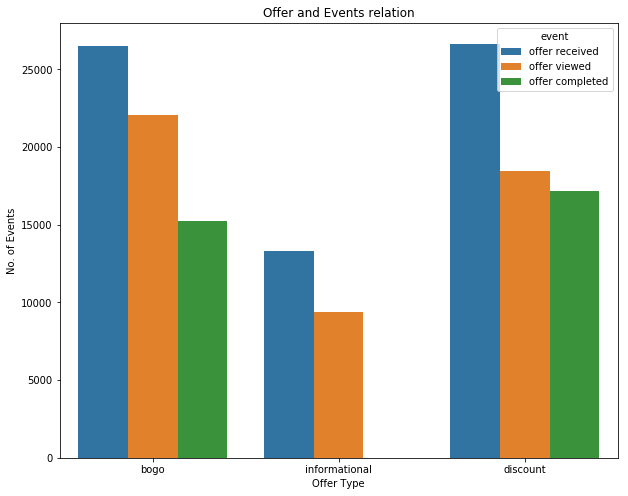

In [271]:
# plot the distrubutions of the events over offer types .

plt.figure(figsize=(10, 8))

sb.countplot(data = final, x ='offer_type' , hue = 'event');

plt.xlabel('Offer Type');
plt.title('Offer and Events relation');
plt.ylabel('No. of Events');

Looking at the plots, Bogo and Discount have the most no. of offeres received and offers completed; Informational type stands at the bottom in comparison to all the offer categories of bogo and discount offers. This also clearly tells us that customers prefer bogo and discount rather than informational offer type. 

There is high chance of succession rate where a customer sent bogo and discount offer types make it to the end i.e completing the offer purchase. It is highly recommended that the company highly focus on its bogo and discount offer and pushing them as much as possible to its customers.

Whereas informatinal offers shouldn'e be neglected completely, we could see that on average it performs pretty solid and there could be some key analysis on what are all the contributing factors that bring in these customers who completed the purchase.

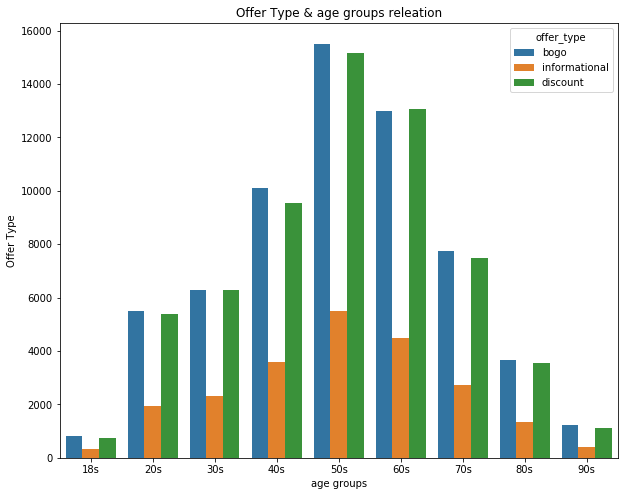

In [270]:
# plot the distrubutions of offer types over ages groups for completed offers only .

plt.figure(figsize=(10, 8))

sb.countplot(data = final, x ='age_group' , hue = 'offer_type' );


plt.xlabel('age groups');
plt.title('Offer Type & age groups releation');
plt.ylabel('Offer Type');

Answering the second part of the problem statement:

The age group of 50s seems to be the majority age group receiving the offer types: bogo and discount. Not sure why it is very high among the 50s age group, but it clearly tells us that this age group should have shown some sign of making it to the offer completion category. 

It is pretty natural that people often get attracted towards bogo and discount categories since it is made to believe that it benefits the user at last.

Lets still look upon which gender utilises these offer more.

In [263]:
offer_completed = final[final['event'] == 'offer completed']
offer_completed.head()

,event,customer_id,time,offer_id,offer_type,age,gender,income,membership_year,membership_month,membership_day,age_group
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,75,F,100000.0,2017,5,Tuesday,70s
8,offer completed,78afa995795e4d85b5d9ceeca43f5fef,21.25,ae264e3637204a6fb9bb56bc8210ddfd,bogo,75,F,100000.0,2017,5,Tuesday,70s
9,offer completed,78afa995795e4d85b5d9ceeca43f5fef,21.25,f19421c1d4aa40978ebb69ca19b0e20d,bogo,75,F,100000.0,2017,5,Tuesday,70s
18,offer completed,e2127556f4f64592b11af22de27a7932,21.75,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,68,M,70000.0,2018,4,Thursday,60s
19,offer completed,e2127556f4f64592b11af22de27a7932,21.75,fafdcd668e3743c1bb461111dcafc2a4,discount,68,M,70000.0,2018,4,Thursday,60s


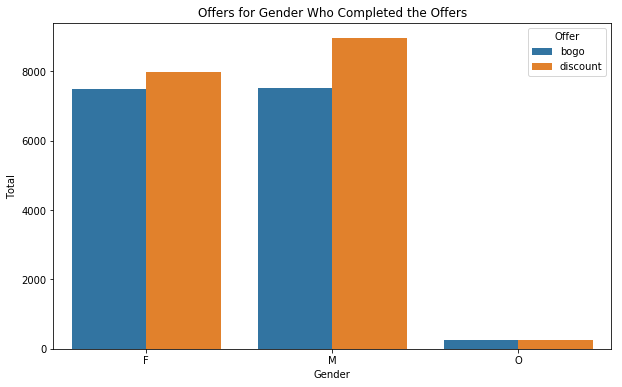

In [267]:
# plot the Popular Offers that offers are completed over gender.

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x= offer_completed.gender, hue=offer_completed.offer_type)

plt.title('Offers for Gender Who Completed the Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)

plt.legend(title='Offer')
plt.show();

Wow! This is something new, initially I just got convinced that females would be the dominating factor as far as the offer completion is focused. Looking at the plots, it is kind of a neck-to-neck move trying t reach the maximum mark. we could clearly see that the completion of bogo offer stands equal among both males and females category. Other category doesn't seem to be in the race actually.

The discount type of offer by males spiked a bit high compared to the females offer completion level. There could be so many factors influencing this, right from the cravings of specific dishes that falls under discount categories. 

<b> <h2> Conclusion: </h2> </b>

Lets revist our problem statement once again:
 
1. Which type of offers influence the customers more allowing the company to push offers better? Analysing the data based on a set of heuristics developed.

2. Identifying the age groups and gender that highly viewed the offer and completed the offer purchase?
i.e. offer received ---> offer viewed ---> offer completed.

In order to answer the first part, I think looking at few of the visualization graphs, it was perfectly evident that BOGO and Discount lead the race leaving informational offer type least importance. As far as promotion is concerned, I think it would be rational enough to focus more and more on BOGO and Discount offers and also trying to restructure the informational offer tyoe which might improve to become a potential category later.

The second part, this was elobarated in detail next to the plots, to summarize, it is straight forward that 50s group were the ones who have high customer base in Starbucks, promoting offers more frequently and particularly to this group could achieve the target of effective offer completion.

<b> Reflection: </b> 

Right from the beginning, this project was challenging and especially, the methods used in the data preprocessing techniques involving pulling years, months and days from the date stamp in transcript dataframe. Portfolio dataframe was clean enough like it didn't have anything strange in particular to spend too much time in preprocessing. With respect to profile dataframe, i think it had few null value which was handled with less efforts. 

Preparing functions/methods to clean up these dataframe was particularly worth in the entire process.

Identfying features from the dataframe, creating new features/columns and merging the dataframes to have a visualization in order to solve the problem statements played a fair role in the challenge.

Getting to know which group, gender availed which type of offers and trying to analyse whether they have completed the offer or just viewd or even just received required a lot of time to answer. 

<b> Improvement: </b> 

I didn't build any ML model over here, my problem statements were clear enough to answer the business end to focus on what types of offers and age groups to promote. 

One improvement that I wish is to implement and deploy a ML model by creating few fresh features that could help your model to predict better. Trying out different Ml algorithms and tuning them accordingly to fetch the maximum accuracy out of it.

Later, Deploying the same using any web app like flask or heroku could be one attractive idea to impress your audience. These are other few things that requires some amount of time and effort to achieve.